[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/saschwarz/yolov8-bbox-segment-anything/blob/main/Yolov8_bbox_segment_anything.ipynb)


## Install/Use MetaSeg Package

https://github.com/kadirnar/segment-anything-video

MetaSeg is under heavy development so API is changing.

In [1]:
!nvidia-smi

Thu Apr 13 22:19:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install metaseg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.2/141.2 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 5.8 MB/s eta 0:00:00
  Created wheel for metaseg: filename=metaseg-0.6.1-py3-none-any.whl size=44772 sha256=63dade0ab9bd1bd50d864688a0d8c24b89a15ff93e42327bcaf51c6410cc15f4
  Stored in directory: /root/.cache/pip/wheels/b1/0c/bd/5e8d8f9aa755ac2f82e75b9391db0d403f760a4654b19c8b6c
Successfully built metas

In [4]:
from metaseg import SegAutoMaskPredictor, SegManualMaskPredictor

## Get test dataset

In [3]:
!git clone https://github.com/saschwarz/yolov8-bbox-segment-anything.git

Cloning into 'yolov8-bbox-segment-anything'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 56 (delta 10), reused 48 (delta 7), pack-reused 0
Unpacking objects: 100% (56/56), 1.01 MiB | 2.48 MiB/s, done.


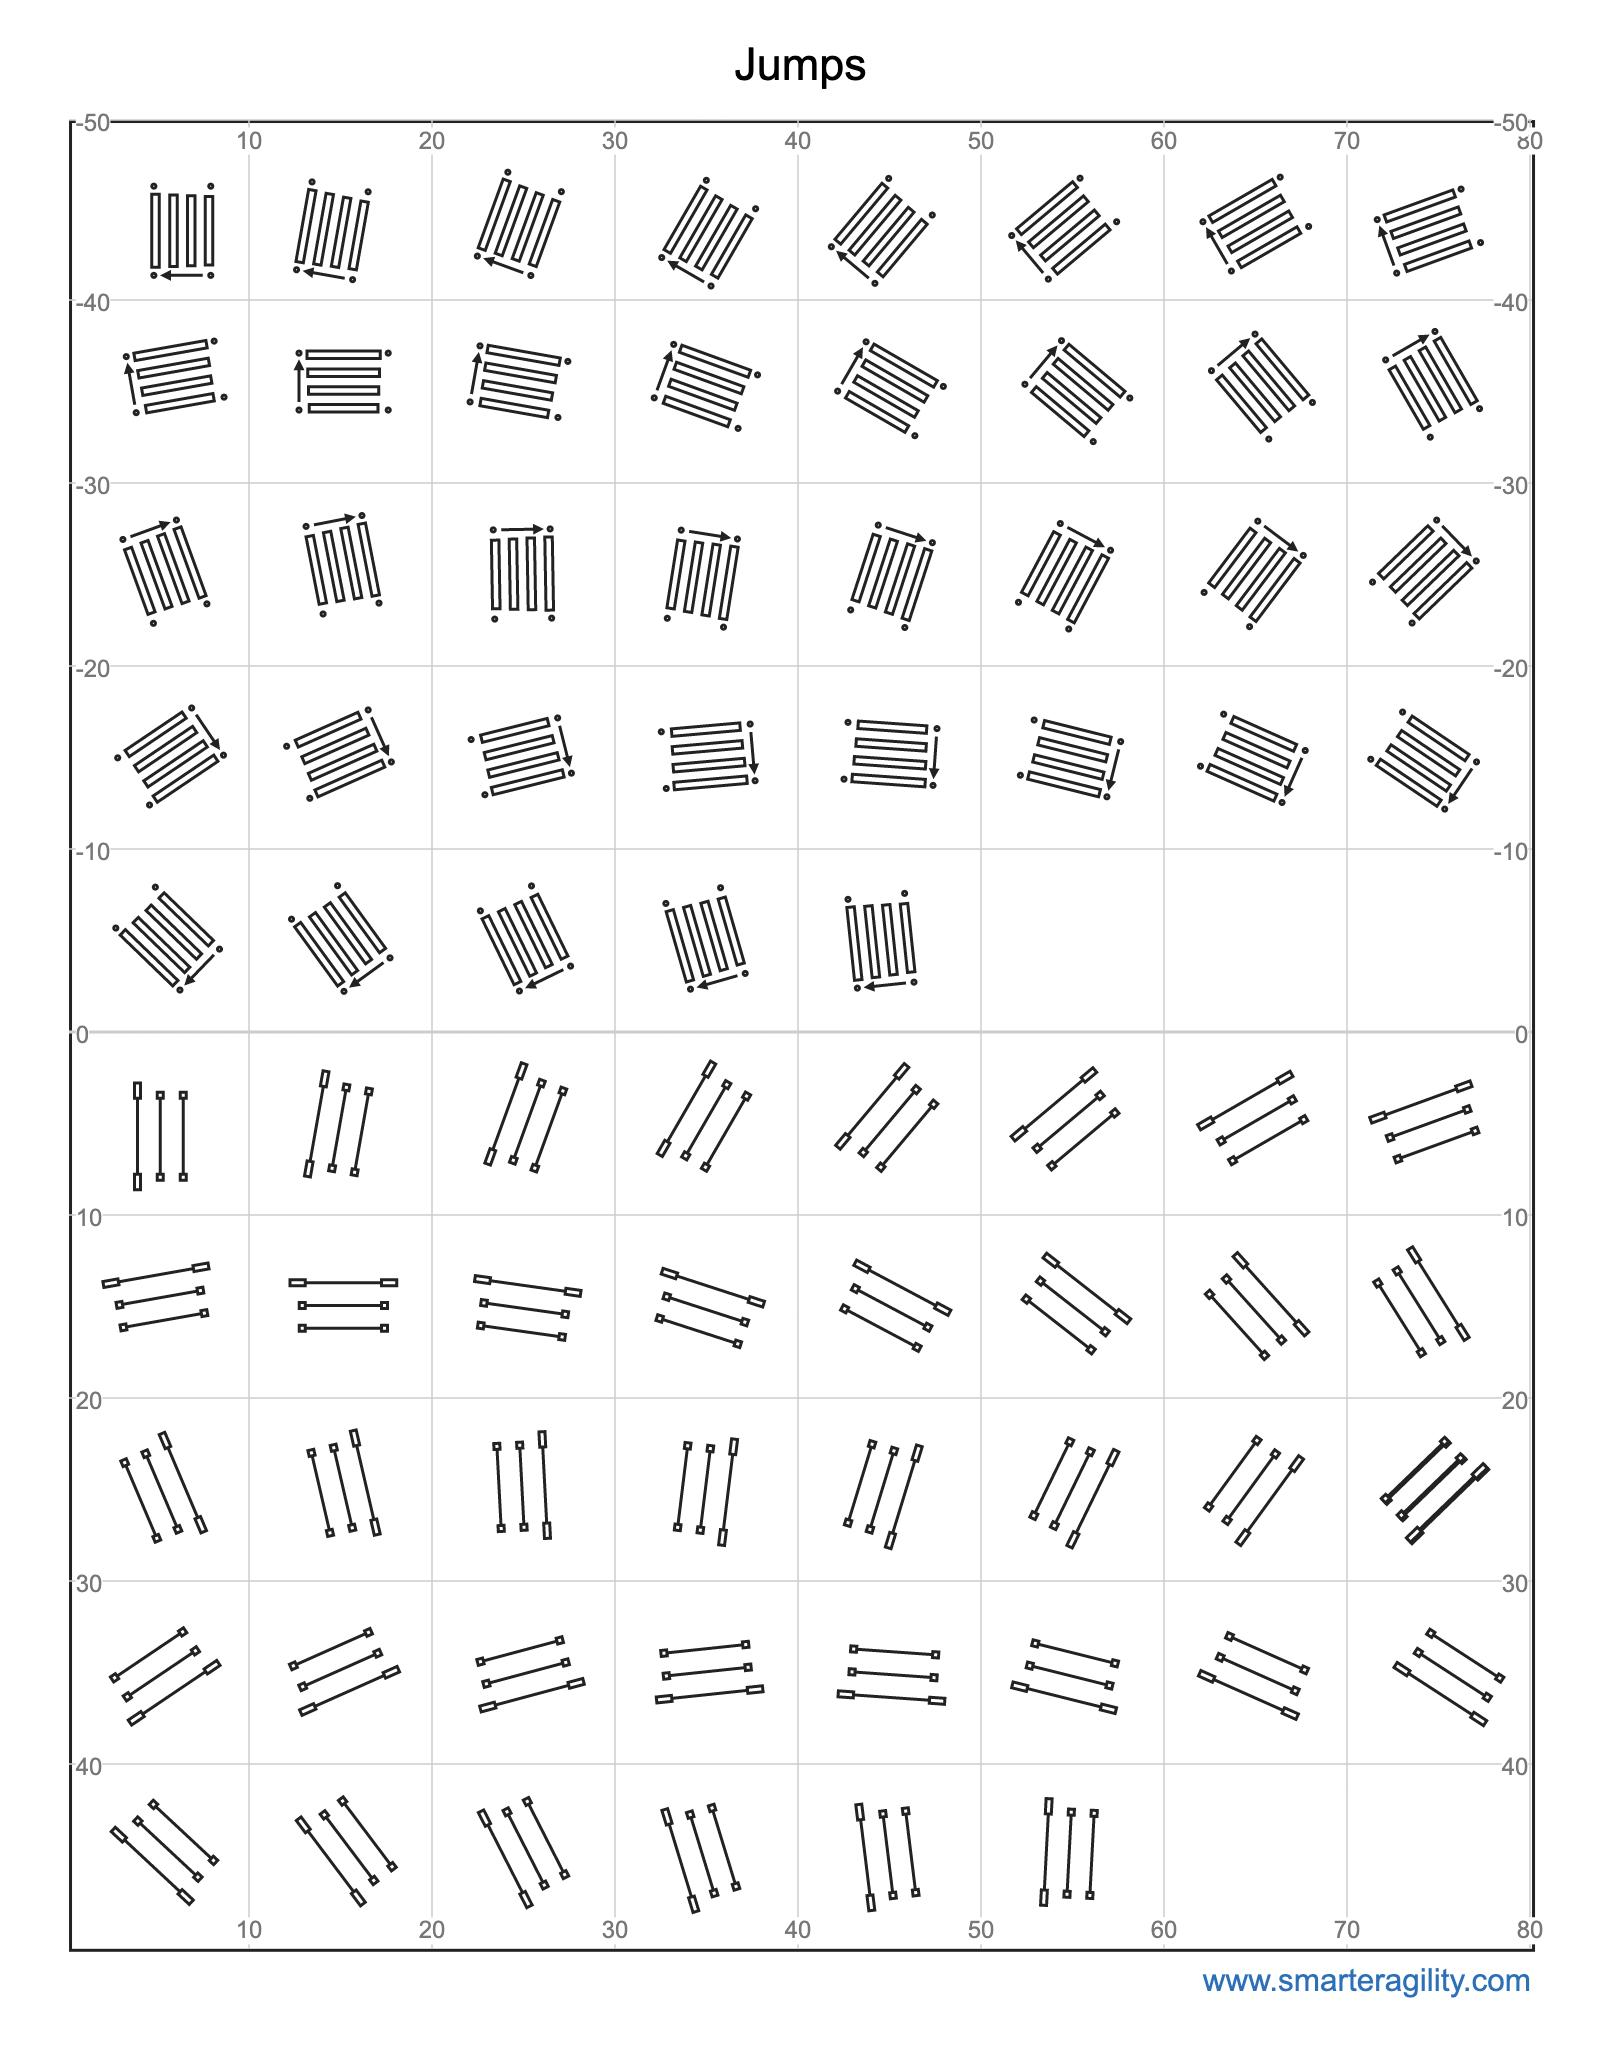

In [6]:
from IPython.display import Image
Image("/content/yolov8-bbox-segment-anything/dataset/test/images/jumps_277237-1-_png.rf.042f0cedb04d03ff80f23bd7409454ad.jpg")

## Use MetaSeg on One Image

vit_l model has been successfully downloaded and saved as 'vit_l.pth'.


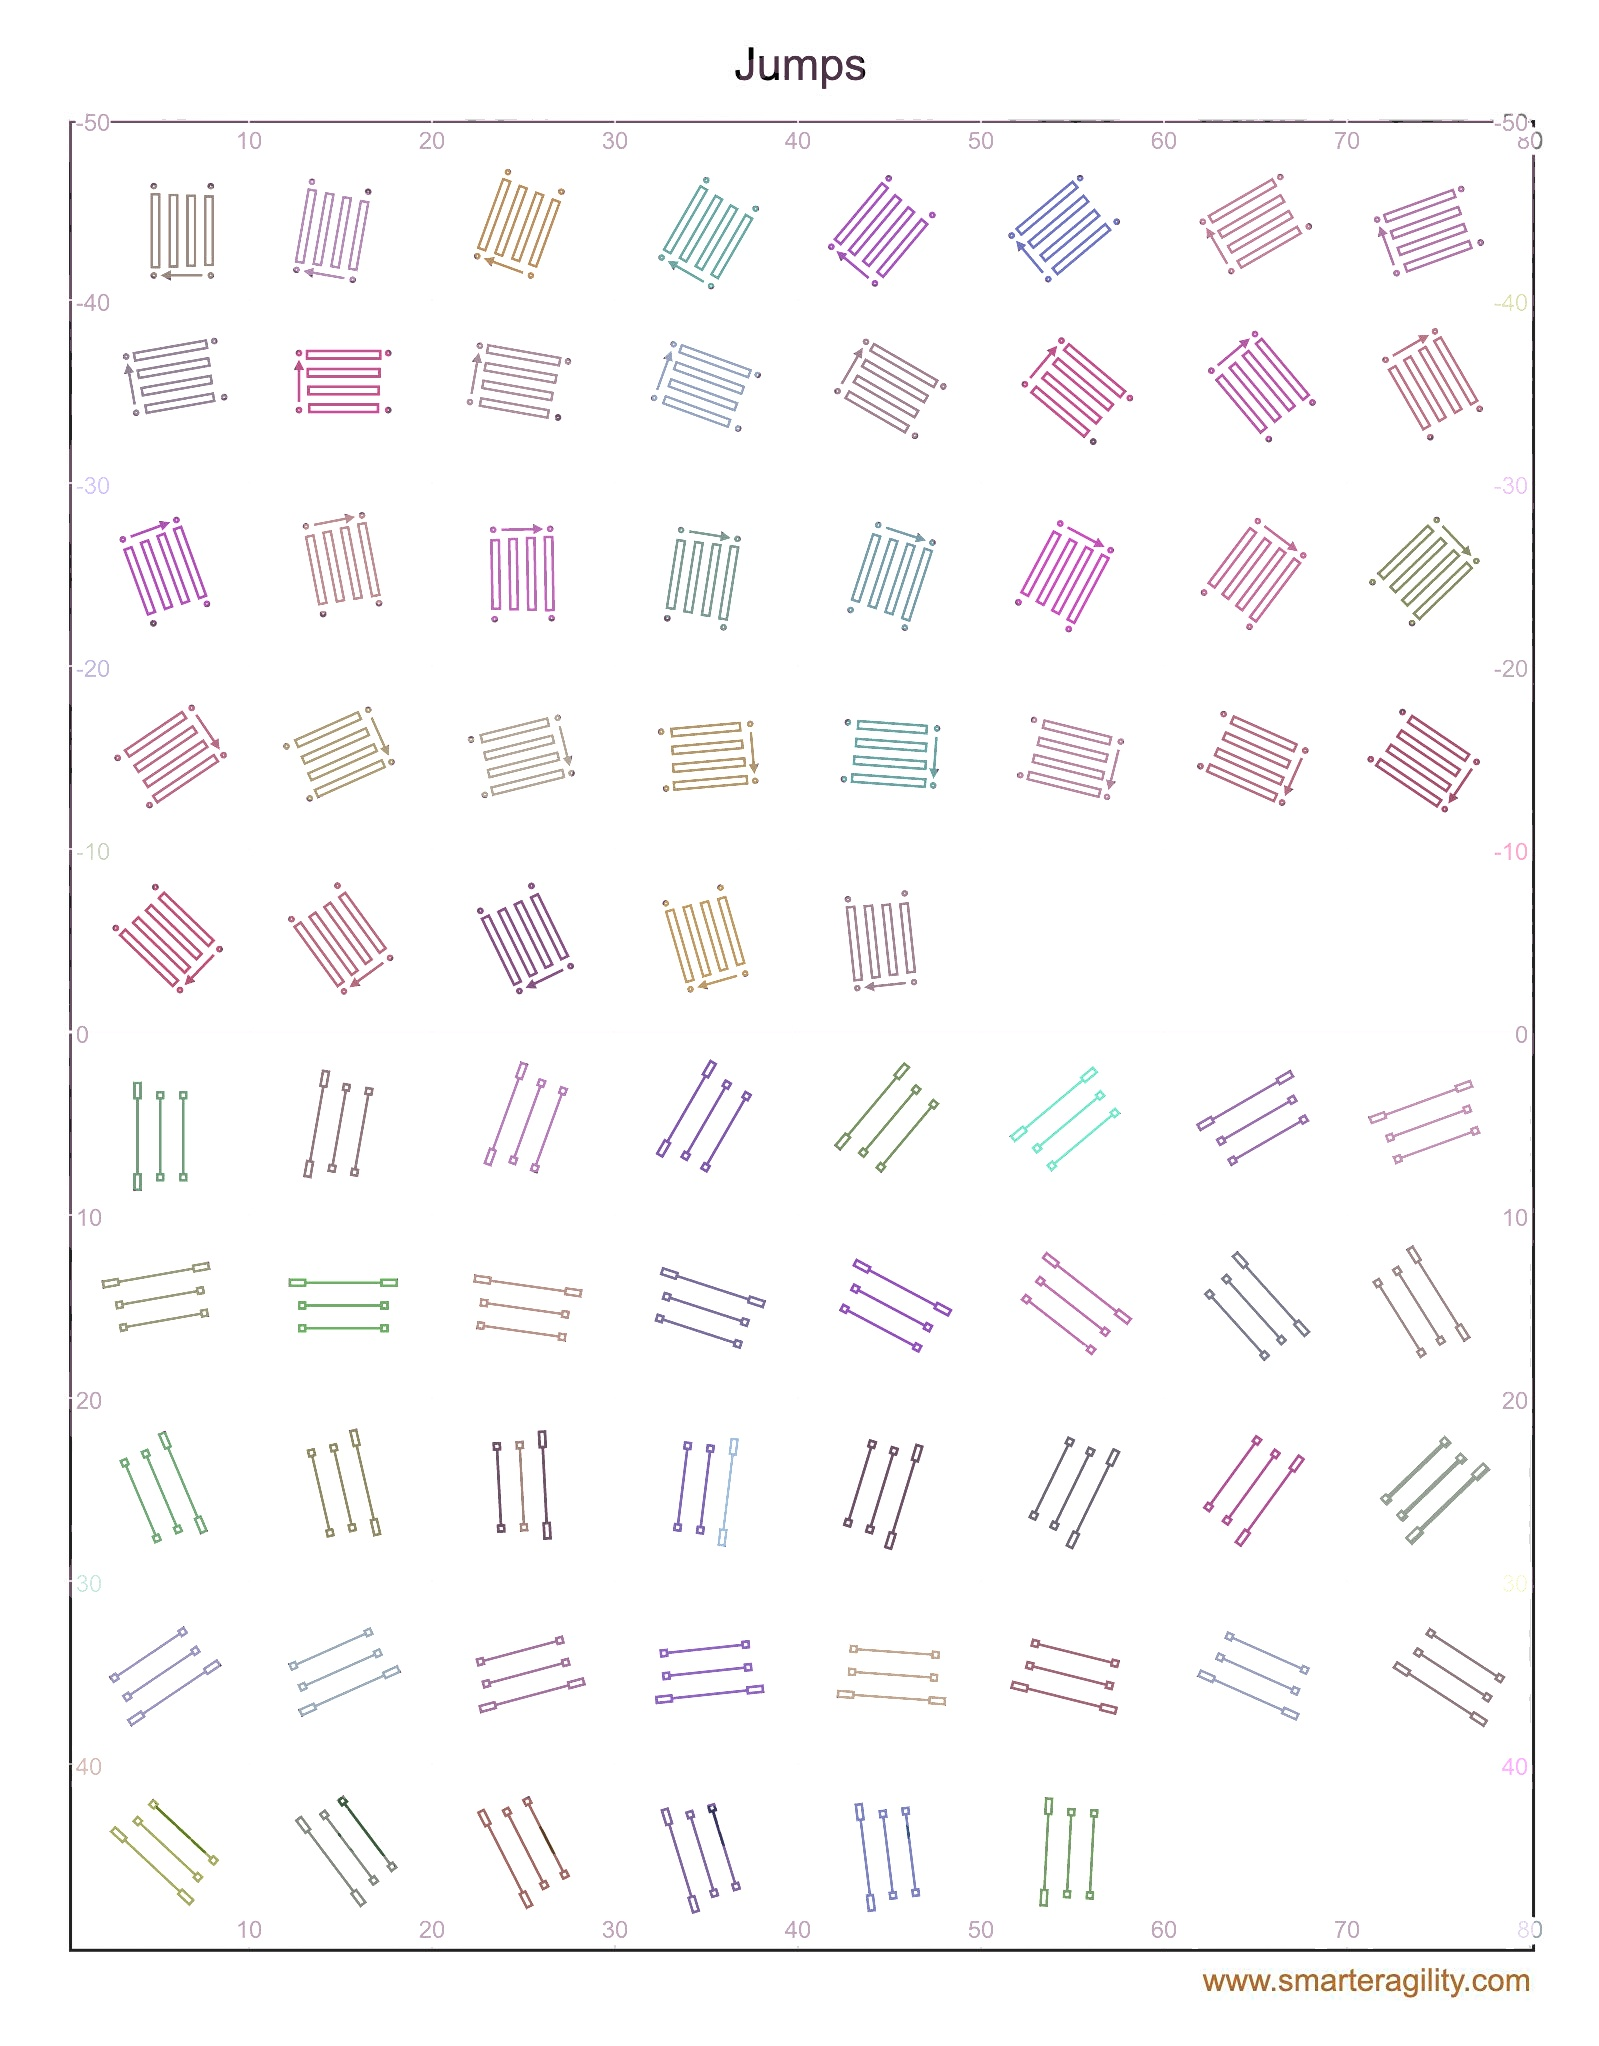

In [7]:
results = codeautoseg_image = SegAutoMaskPredictor().image_predict(
    source="/content/yolov8-bbox-segment-anything/dataset/test/images/jumps_277237-1-_png.rf.042f0cedb04d03ff80f23bd7409454ad.jpg",
    model_type="vit_l",
    points_per_side=32, 
    points_per_batch=64,
    min_area=0,
    output_path="output.jpg",
    save=True
)
# print(results)
Image("output.jpg")

## Apply MetaSeg tto Generate Segmentation Annotations to Using Existing Bounding Boxes

In [8]:
!pip install globox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
from globox import AnnotationSet, BoundingBox
import json
from pathlib import Path
import cv2

ROOT = Path("/content/yolov8-bbox-segment-anything/dataset/train/")
IMAGE_ROOT = ROOT / "images"
LABEL_ROOT = ROOT / "labels"

gts = AnnotationSet.from_yolo_v7(    
    folder=LABEL_ROOT,
    image_folder=IMAGE_ROOT)

# gts.show_stats()

for filename, annotation in gts.items():
  print(filename, annotation.image_width, annotation.image_height, len(annotation.boxes))
  # for idx, bbox in enumerate(annotation.boxes[10:]):
  full_path = str(IMAGE_ROOT / filename)
  #   image = cv2.imread(full_path)
  #   copy = image.copy()
  #   print(bbox)
  #   print(idx, full_path)
  #   print(bbox.xmin, bbox.ymin, bbox.xmax, bbox.ymax)
  #   # cv2.rectangle(copy, 
  #   #               [int(bbox.xmin), int(bbox.ymin)], 
  #   #               [int(bbox.xmax), int(bbox.ymax)], 
  #   #               (0, 0, 255), 2)
  idx = 0
  output = f"{filename}-{idx}.png"
  #   # cv2.imwrite(output, copy)
  #   # Image(output)    
  input_boxes = [[int(b.xmin), int(b.ymin), int(b.xmax), int(b.ymax)] for b in annotation.boxes]
  print(input_boxes)
  try:
    result = SegManualMaskPredictor().image_predict(
        source=full_path,
        model_type="vit_l",
        input_point=None,
        input_label=None,
        input_box=input_boxes,  # [int(bbox.xmin), int(bbox.ymin), int(bbox.xmax), int(bbox.ymax)],
        multimask_output=False,
        random_color=True,
        save=True,
        output_path="output.png"
    )
    print(result)
    Image(output)
  except Exception as e:
    print(e)


jumps-3_277225_png.rf.a788d4e02595959f5f497670dab7d536.jpg 1599 2046 73
[[144, 150, 191, 287], [304, 149, 361, 282], [483, 158, 553, 288], [660, 156, 739, 281], [821, 159, 931, 274], [1016, 157, 1137, 262], [1183, 170, 1318, 266], [1361, 176, 1492, 250], [1380, 326, 1469, 453], [1197, 332, 1301, 443], [1002, 342, 1120, 445], [816, 337, 940, 430], [635, 359, 765, 427], [457, 371, 581, 426], [266, 363, 412, 431], [97, 361, 224, 415], [136, 522, 216, 644], [310, 518, 366, 640], [1232, 501, 1283, 631], [1388, 499, 1455, 623], [1369, 731, 1491, 782], [1188, 731, 1326, 772], [1011, 723, 1137, 772], [829, 721, 953, 790], [649, 715, 772, 805], [470, 703, 582, 804], [286, 700, 388, 820], [124, 695, 209, 813], [99, 881, 232, 983], [278, 888, 405, 984], [460, 890, 572, 986], [658, 870, 762, 988], [849, 874, 938, 988], [1032, 859, 1113, 992], [1232, 865, 1295, 991], [1404, 859, 1440, 995], [137, 1066, 200, 1202], [296, 1067, 370, 1196], [474, 1056, 555, 1184], [649, 1054, 748, 1194], [825, 1061, 9